In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


### Utility functions

In [6]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [7]:
img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)
print(res)

5 4 11 1 13 1 16 4


In [60]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [11]:
res = rle2mask("5 4 11 1 13 1 16 4", *(5, 5))
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


### Data Generators

In [142]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT =128
TRAIN_IMG_SIZE_WIDTH = 800

BATCH_SIZE = 1

In [22]:
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = './input/severstal-steel-defect-detection/train_images/'
        elif self.subset == "test":
            self.data_path = './input/severstal-steel-defect-detection/test_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,1),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            print(f)
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train': 
                mask_i = rle2mask(self.df['EncodedPixels'].iloc[indexes[i]], *(256, 1600))
                img_mask_i = Image.fromarray(mask_i, '1')
                y[i,:,:,0] = 
                #y = np.expand_dims(y, axis=2)
                
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

In [172]:
class SimpleDataGenerator(keras.utils.Sequence):
    def __init__(self, df, img_path, orig_img_shape, new_img_shape=None, batch_size = BATCH_SIZE, n_channels=1,
                 n_classes=4, shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.orig_img_shape = orig_img_shape
        if new_img_shape:
            self.new_img_shape = new_img_shape
        else:
            self.new_img_shape = orig_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
        print(f'self.orig_img_shape: {self.orig_img_shape}')
        print(f'self.new_img_shape: {self.new_img_shape}')
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.new_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.new_img_shape, 1), dtype=np.float32)
        
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            if self.orig_img_shape != self.new_img_shape:
                img = cv2.resize(img, tuple(reversed(self.new_img_shape)), interpolation=cv2.INTER_AREA)
            print(f'Filename: {filename}')
            print(f'final img shape: {img.shape}')
            X[idx,] = img
            
            mask_i = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *self.orig_img_shape)
            print(f'Mask shape: {mask_i.shape}')
            
            img_mask_i = Image.fromarray(mask_i, 'L')
            plt.imshow(img_mask_i)
            print(f'Img mash shape: {img_mask_i.size}')
            if self.orig_img_shape != self.new_img_shape:
                img_mask_i = img_mask_i.resize(tuple(reversed(self.new_img_shape)))
            print(f'final img mask shape: {img_mask_i.size}')
            y[idx,:,:,0] = img_mask_i
            
        return X, y

In [ ]:
class SimpleDataGenerator(keras.utils.Sequence):
    def __init__(self, df, img_path, orig_img_shape, new_img_shape=None, batch_size = BATCH_SIZE, n_channels=1,
                 n_classes=4, shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.orig_img_shape = orig_img_shape
        if new_img_shape:
            self.new_img_shape = new_img_shape
        else:
            self.new_img_shape = orig_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
        print(f'self.orig_img_shape: {self.orig_img_shape}')
        print(f'self.new_img_shape: {self.new_img_shape}')
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.new_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.new_img_shape, 1), dtype=np.float32)
        
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            if self.orig_img_shape != self.new_img_shape:
                img = cv2.resize(img, tuple(reversed(self.new_img_shape)), interpolation=cv2.INTER_AREA)
            print(f'Filename: {filename}')
            print(f'final img shape: {img.shape}')
            X[idx,] = img
            
            mask_i = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *self.orig_img_shape)
            print(f'Mask shape: {mask_i.shape}')
            
            img_mask_i = Image.fromarray(mask_i, 'L')
            plt.imshow(img_mask_i)
            print(f'Img mash shape: {img_mask_i.size}')
            if self.orig_img_shape != self.new_img_shape:
                img_mask_i = img_mask_i.resize(tuple(reversed(self.new_img_shape)))
            print(f'final img mask shape: {img_mask_i.size}')
            y[idx,:,:,0] = img_mask_i
            
        return X, y

self.orig_img_shape: (256, 1600)
self.new_img_shape: (64, 400)
X shape: (1, 64, 400, 3)
y shape: (1, 64, 400, 1)
Filename: 008d0f87b.jpg
final img shape: (64, 400, 3)
Mask shape: (256, 1600)
Img mash shape: (1600, 256)
final img mask shape: (400, 64)
(1, 64, 400, 3)
(1, 64, 400, 1)
(64, 400, 3)
(64, 400, 1)


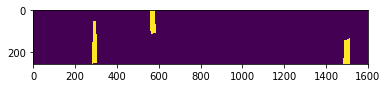

In [173]:
idx = int(0.8*len(df_train))

#train_batches = DataGenerator(df_train.iloc[:idx],shuffle=False,preprocess=None)
#valid_batches = DataGenerator(df_train.iloc[idx:],preprocess=None)

train_batches = SimpleDataGenerator(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    orig_img_shape=(256, 1600), new_img_shape=(64, 400), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, shuffle=False)
#valid_batches = SimpleDataGenerator(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
#                                    orig_img_shape=(256, 1600), new_img_shape=(128, 800), batch_size = BATCH_SIZE, 
#                                    n_channels=3, n_classes=4, shuffle=False)

X, y = train_batches.__getitem__(17) 
print(X.shape)
print(y.shape)
print(X[0].shape)
print(y[0].shape)
#print(train_batches.__getitem__(0)[1][0].shape)


<class 'numpy.ndarray'>
Data shape: (64, 400, 3)


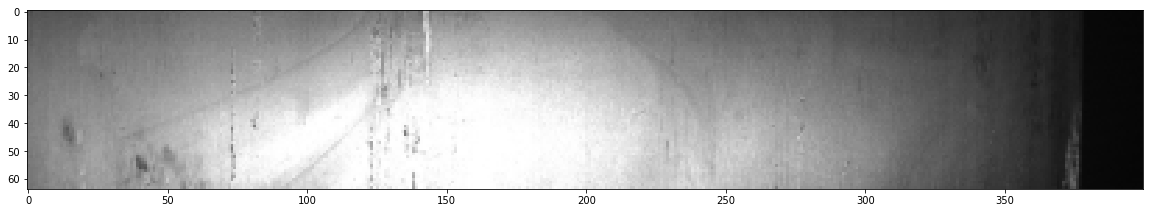

In [174]:
#img = Image.fromarray(data)
#img.save('my.png')
#img.show()
plt.figure(figsize=(20,4))

data = X[0]
print(type(data))
print(f'Data shape: {data.shape}')

if (data.shape[2] == 1):
    plt.imshow(np.squeeze(data, axis=2), cmap="gray")
else:
    plt.imshow(data.astype(int))

#plt.figure(figsize=(10,20))
plt.show()

<class 'numpy.ndarray'>
Data shape: (64, 400, 1)


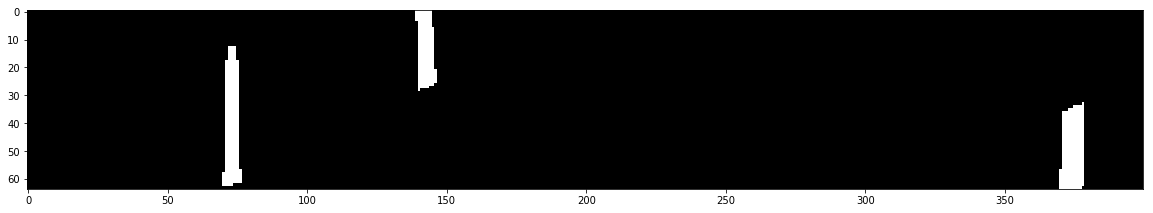

In [175]:
plt.figure(figsize=(20,4))

data = y[0]
print(type(data))
print(f'Data shape: {data.shape}')


if (data.shape[2] == 1):
    plt.imshow(np.squeeze(data, axis=2), cmap="gray")
else:
    plt.imshow(data.astype(int))

#plt.figure(figsize=(10,20))
plt.show()

In [64]:
df_train.loc[df_train['ImageId']=='01053d28f.jpg']['EncodedPixels'].values[0]

'43063 3 43319 8 43575 13 43831 18 44087 23 44343 26 44599 26 44855 26 45111 26 45367 26 45623 27 45879 27 46135 27 46391 27 46647 27 46903 27 47159 27 47415 27 47671 27 47927 28 48183 28 48439 28 48695 28 48951 28 49207 25 49463 19 49719 14 49975 9 50231 3 50477 9 50732 27 50987 44 51243 61 51498 71 51753 73 52008 75 52264 75 52519 77 52774 79 53029 81 53284 82 53540 83 53795 85 54050 87 54305 88 54560 90 54816 91 55071 90 55326 89 55581 88 55837 86 56092 85 56347 84 56609 75 56877 61 57144 48 57412 34 57679 21 57947 7 58986 41 59242 41 59498 41 59754 41 60010 41 60266 42 60522 42 60777 43 61033 43 61289 43 61545 43 61737 36 61801 43 61993 36 62057 43 62249 36 62313 44 62505 36 62569 44 62761 36 62825 44 63017 36 63081 44 63273 36 63337 44 63529 36 63593 44 63785 36 63848 45 64041 36 64104 45 64297 36 64360 46 64554 35 64616 46 64810 34 64872 46 65066 34 65128 46 65322 34 65407 23 65578 34 65834 34 66090 34 66346 34 66602 34 66858 34 67023 4 67123 25 67279 10 67395 9 67535 17 67791 23

(256, 1600, 3)


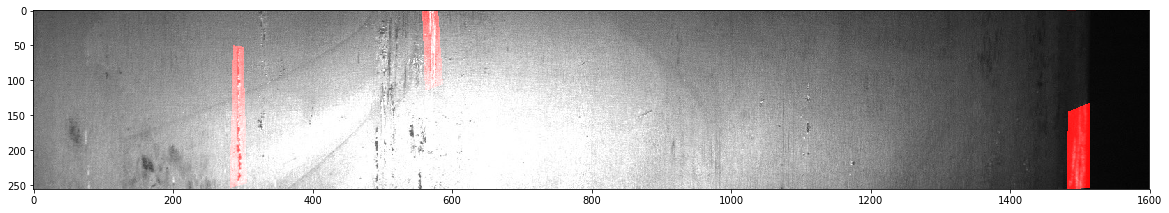

In [147]:
plt.figure(figsize=(20,4))

img = cv2.imread( './input/severstal-steel-defect-detection/train_images/008d0f87b.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = rle2mask(df_train.loc[df_train['ImageId']=='008d0f87b.jpg']['EncodedPixels'].values[0], img.shape[0], img.shape[1])
img[mask==1,0] = 255
print(img.shape)
plt.imshow(img)

plt.show()